In [1]:
import numpy as np
import librosa #imports audio/music packages
import librosa.display #displays spectrograms
import os
import csv
%matplotlib inline
import matplotlib.pyplot as plt #plots spectrogram
import random

In [2]:
train_dir = 'train/audio/' #download files from kaggle

classes = ['yes', 'no', 
           'up', 'down', 
           'left', 'right', 
           'on', 'off', 
           'stop', 'go', 
           'silence', 'unknown']

In [ ]:
%%bash\n
mv train/audio/_background_noise_ data/train\n
ls train

In [4]:
def split_arr(arr): #turns all audio into 1 sec frames
    """
    split an array into chunks of length 16000
    Returns:
        list of arrays
    """
    return np.split(arr, np.arange(16000, len(arr), 16000))

In [5]:
def create_silence(): #creates silence files
    """
    reads wav files in background noises folder, 
    splits them and saves to silence folder in train_dir
    """
    for file in os.listdir('train/_background_noise_/'):
        if 'wav' in file:
            sig, rate = librosa.load('train/_background_noise_/' + file, sr = 16000)        
            sig_arr = split_arr(sig)
            if not os.path.exists(train_dir+'silence/'):
                os.makedirs(train_dir+'silence/')
            for ind, arr in enumerate(sig_arr):
                filename = 'frag%d' %ind + '_%s' %file # example: frag0_running_tap.wav
                librosa.output.write_wav(train_dir+'silence/'+filename, arr, 16000)

In [6]:
create_silence()

In [7]:
folders = os.listdir(train_dir) #displays words in audio recordings
# put folders in same order as in the classes list, used when making sets
all_classes = [x for x in classes[:11]]
for ind, cl in enumerate(folders):
    if cl not in classes:
        all_classes.append(cl)
print(all_classes)


['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'dog', '.ipynb_checkpoints', 'bird', 'sheila', 'eight', 'five', 'cat', 'zero', 'six', 'house', 'tree', 'bed', 'wow', 'four', 'three', 'nine', 'two', 'seven', 'marvin', 'one', 'happy']


In [8]:
with open('train/validation_list.txt') as val_list: 
    validation_list = [row[0] for row in csv.reader(val_list)]
assert len(validation_list) == 6798, 'file not loaded'

"""
#if you want to add the files in testing_list.txt to the validation list:

with open('./data/train/testing_list.txt') as test_list:
    testing_list = [row[0] for row in csv.reader(test_list)]
assert len(testing_list) == 6835, 'file not loaded'

#combine into validation set
validation_list.extend(testing_list)
"""
#add silence files to validation_list
for i, file in enumerate(os.listdir(train_dir + 'silence/')):
    if i%10==0:
        validation_list.append('silence/'+file)

training_list = []
all_files_list = []
class_counts = {}

for folder in folders:
    files = os.listdir(train_dir + folder)
    for i, f in enumerate(files):
        all_files_list.append(folder + '/' + f)
        path = folder + '/' + f
        if path not in validation_list:
            training_list.append(folder + '/' + f)        
        class_counts[folder] = i

#remove filenames from validation_list that don't exist anymore (due to eda)
validation_list = list(set(validation_list).intersection(all_files_list))

In [9]:
assert len(validation_list)+len(training_list)==len(all_files_list), 'error'

In [10]:
# check random file name
print(training_list[345], 'size training set: ',len(training_list), 'size validation set: ', len(validation_list))

silence/frag41_white_noise.wav size training set:  58284 size validation set:  6839


In [11]:
print(class_counts)

{'silence': 401, 'dog': 1745, 'bird': 1730, 'sheila': 1733, 'eight': 2351, 'five': 2356, 'cat': 1732, 'down': 2358, 'zero': 2375, 'on': 2366, 'six': 2368, 'house': 1749, 'tree': 1732, 'right': 2366, 'no': 2374, 'bed': 1712, 'wow': 1744, 'four': 2371, 'stop': 2379, 'three': 2355, 'nine': 2363, 'two': 2372, 'seven': 2376, 'marvin': 1745, 'up': 2374, 'go': 2371, 'off': 2356, 'yes': 2376, 'left': 2352, 'one': 2369, 'happy': 1741}


min:  -0.1182251 
max:  0.10827637 
mean:  7.842428e-06 
median:  0.0 
variance:  0.0003236237 
length:  10923


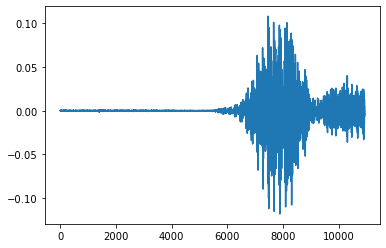

In [12]:
x, r = librosa.load(train_dir + 'yes/bfdb9801_nohash_0.wav', sr = 16000)
print('min: ',np.min(x), 
      '\nmax: ', np.max(x), 
      '\nmean: ', np.mean(x),
      '\nmedian: ', np.median(x),
      '\nvariance: ', np.var(x),
      '\nlength: ', len(x))
plt.plot(x)

In [13]:
def make_spec(file, file_dir = train_dir, flip = False, ps = False, st = 4): #constructs all wave files into spectrograms
    """
    create a melspectrogram from the amplitude of the sound
    
    Args:
        file (str): filename
        file_dir (str): directory path
        flip (bool): reverse time axis
        ps (bool): pitch shift
        st (int): half-note steps for pitch shift
    Returns:
        np.array with shape (122,85) (time, freq)
    """
    sig, rate = librosa.load(file_dir + file, sr = 16000)
    if len(sig) < 16000: # pad shorter than 1 sec audio with ramp to zero
        sig = np.pad(sig, (0,16000-len(sig)), 'linear_ramp')
    if ps:
        sig = librosa.effects.pitch_shift(sig, rate, st)
    D = librosa.amplitude_to_db(librosa.stft(sig[:16000], n_fft = 512, 
                                             hop_length = 128, 
                                             center = False), ref = np.max)
    S = librosa.feature.melspectrogram(S=D, n_mels = 85).T
    if flip:
        S = np.flipud(S)
    return S.astype(np.float32)

/opt/conda/envs/speechrecognition/lib/python3.7/site-packages/librosa/core/spectrum.py:1702: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


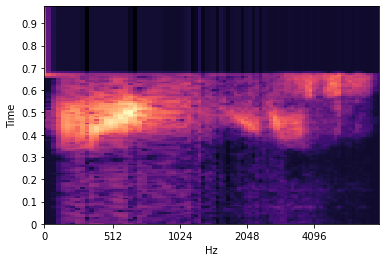

In [14]:
librosa.display.specshow(make_spec('yes/bfdb9801_nohash_0.wav'), 
                         x_axis='mel', 
                         fmax=8000, 
                         y_axis='time', 
                         sr = 16000,
                         hop_length = 128)

In [15]:
make_spec('yes/bfdb9801_nohash_0.wav').shape

(122, 85)

In [16]:
def create_sets(file_list = training_list):
    X_array = np.zeros([len(file_list),122,85])
    Y_array = np.zeros([len(file_list)])    
    for ind, file in enumerate(file_list):
        if ind%2000 == 0:
            print(ind, file)
        try:
            X_array[ind] = make_spec(file)
        except ValueError:
            print(ind, file, ValueError)
        Y_array[ind] = all_classes.index(file.rsplit('/')[0])
        
    return X_array, Y_array

In [17]:
X_train, Y_train_all = create_sets() # takes a while

0 silence/frag65_doing_the_dishes.wav
2000 bird/88053e92_nohash_0.wav
4000 sheila/b575b5fb_nohash_0.wav
6000 eight/bbd0bbd0_nohash_1.wav
8000 five/1ecfb537_nohash_4.wav
10000 cat/c37a72d3_nohash_0.wav
12000 down/bf4af1af_nohash_0.wav
14000 zero/41dce6f5_nohash_0.wav
16000 on/c948d727_nohash_4.wav
18000 six/784e281a_nohash_0.wav
20000 house/637c702a_nohash_1.wav
28000 bed/8ec6dab6_nohash_0.wav
30000 four/eb0676ec_nohash_1.wav
32000 stop/e9b61425_nohash_0.wav
34000 three/96ab6565_nohash_3.wav
36000 three/7be9f58a_nohash_0.wav
38000 nine/5c39594f_nohash_4.wav
40000 two/778a4a01_nohash_1.wav
42000 seven/9f63152b_nohash_0.wav
44000 marvin/0ac15fe9_nohash_0.wav
46000 up/94de6a6a_nohash_1.wav
48000 go/fb7cfe0e_nohash_0.wav
50000 off/742d6431_nohash_3.wav
52000 yes/b87bdb22_nohash_2.wav
54000 left/28e47b1a_nohash_0.wav
56000 one/f63a6479_nohash_0.wav
58000 happy/b3849d6e_nohash_0.wav


In [18]:
# all unknown are index 11
Y_train = np.where(Y_train_all < 11, Y_train_all, 11)

In [19]:
print(len(Y_train) == len(Y_train_all), 12 in Y_train)

True False


In [20]:
X_train.shape

(58284, 122, 85)

In [21]:
Y_train_all.shape

(58284,)

In [22]:
Y_train.shape

(58284,)

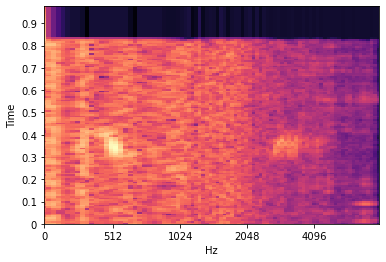

In [23]:
librosa.display.specshow(X_train[6500], #displays a spectrogram
                         x_axis='mel', 
                         fmax=8000, 
                         y_axis='time', 
                         sr = 16000,
                         hop_length = 128)

In [24]:
print('min: ',np.min(X_train), 
      '\nmax: ', np.max(X_train), 
      '\nmean: ', np.mean(X_train),
      '\nmedian: ', np.median(X_train),
      '\nvariance: ', np.var(X_train))

min:  -2.0306179523468018 
max:  9.682740653715882e-08 
mean:  -1.3092300794471547 
median:  -1.3604835271835327 
variance:  0.19676181601647008


(array([ 1228696.,   145193.,  3275025.,  7532804., 82702716., 22856634.,
        16916704., 16934796., 16204825., 16512879., 17009318., 17513302.,
        18006812., 18386291., 18671257., 18840020., 18900237., 18844196.,
        18652590., 18316823., 17823879., 17199133., 16469637., 15675213.,
        14854687., 14015045., 13174262., 12327566., 11507182., 10714156.,
         9950829.,  9217051.,  8526898.,  7885926.,  7288961.,  6747406.,
         6245523.,  5775195.,  5310557.,  4841611.,  4364017.,  3884664.,
         3374695.,  2829794.,  2268462.,  1743245.,  1304578.,   865137.,
          526567.,   242086.]),
 array([-2.03061795e+00, -1.99000559e+00, -1.94939323e+00, -1.90878087e+00,
        -1.86816851e+00, -1.82755615e+00, -1.78694379e+00, -1.74633143e+00,
        -1.70571906e+00, -1.66510670e+00, -1.62449434e+00, -1.58388198e+00,
        -1.54326962e+00, -1.50265726e+00, -1.46204490e+00, -1.42143254e+00,
        -1.38082018e+00, -1.34020782e+00, -1.29959545e+00, -1.25898309e+

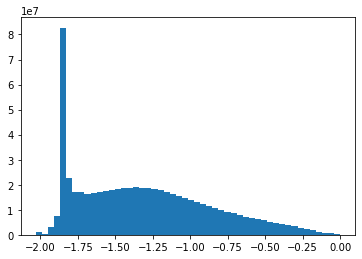

In [25]:
plt.hist(X_train.flatten(), bins = 50)

In [26]:
np.save('X_train.npy', np.expand_dims(X_train, -1)+1.3)
np.save('Y_train.npy', Y_train.astype(np.int))
np.save('Y_train_all.npy', Y_train_all.astype(np.int))


In [27]:
X_val, Y_val_all = create_sets(file_list = validation_list)

0 four/dca2797e_nohash_4.wav
2000 bed/f5e5e8b0_nohash_1.wav
4000 zero/56eb74ae_nohash_0.wav
6000 go/c2d15ea5_nohash_0.wav


In [28]:
Y_val = np.where(Y_val_all < 11, Y_val_all, 11)


(array([  154940.,    18034.,   411645.,   957655., 10309003.,  2858927.,
         2146578.,  2155734.,  2049895.,  2059563.,  2087882.,  2115112.,
         2131931.,  2143110.,  2147229.,  2145523.,  2141245.,  2122489.,
         2093430.,  2053423.,  2001739.,  1938333.,  1861705.,  1778818.,
         1684598.,  1584731.,  1481878.,  1378238.,  1284468.,  1188649.,
         1100951.,  1022830.,   947062.,   880444.,   816628.,   754606.,
          701733.,   649502.,   594099.,   543359.,   491538.,   438045.,
          382877.,   320595.,   257847.,   198923.,   146399.,    98751.,
           61642.,    26094.]),
 array([-2.03061795e+00, -1.99000559e+00, -1.94939323e+00, -1.90878087e+00,
        -1.86816851e+00, -1.82755615e+00, -1.78694379e+00, -1.74633143e+00,
        -1.70571906e+00, -1.66510670e+00, -1.62449434e+00, -1.58388198e+00,
        -1.54326962e+00, -1.50265726e+00, -1.46204490e+00, -1.42143254e+00,
        -1.38082018e+00, -1.34020782e+00, -1.29959546e+00, -1.25898309e+

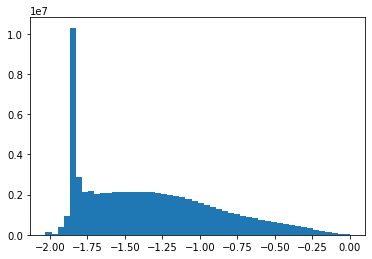

In [29]:
plt.hist(X_val.flatten(), bins = 50)


In [30]:
np.save('X_val.npy', np.expand_dims(X_val, -1)+1.3)
np.save('Y_val.npy', Y_val.astype(np.int))
np.save('Y_val_all.npy', Y_val_all.astype(np.int))